In [39]:
import pandas as pd
import numpy as np
import re
import collections, itertools
import numpy as np
import matplotlib.pyplot as plt
import nltk
import hdbscan
import umap
import gensim

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.probability import FreqDist

from finbert_embedding.embedding import FinbertEmbedding

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import corpora
from gensim.corpora.dictionary import Dictionary

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
import glob
list_articles = glob.glob("data/earning_call/*")
texts = []
for s in list_articles:
    with open(s) as f:
        texts.append(f.read())

In [10]:
'Number of articles', len(texts)

('Number of articles', 444)

## Processing

In [11]:
# Function that transforms a list of strings into 1 big concatenated string and vice-versa
def list_to_text(list_input, stops = []):
    text_output = ' '.join([word for word in list_input if word not in stops]) 
    return text_output

def text_to_list(text_input):
    list_output = word_tokenize(text_input)
    return list_output

In [12]:
text = 'blablabla'
# Ponctuation
text = re.sub('[^A-Za-z0-9]+', ' ', text)

# Lower all words
text = text.lower()

# Remove stopwords
stop_words = set(stopwords.words('english'))
word_tokens = word_tokenize(text)
filtered_text = [w for w in word_tokens if not w.lower() in stop_words]

print('Number of words before removing the stop words',len(word_tokens))
print('Number of words after removing the stop words',len(filtered_text))

Number of words before removing the stop words 1
Number of words after removing the stop words 1


In [13]:
# N-Gram
def ngrams_list(n):
    """
        Compute ngrams.
        
        Args:
            n (int): the number of words to words to assemble in the ngram.
        
        Returns :
            A list composed of the ngrams.
    """
    m = []
    nx_grams = ngrams(sequence = nltk.word_tokenize(text), n = n)
    for gram in nx_grams:
        m.append(gram)
    return m

In [14]:
wordnet_lemmatizer = WordNetLemmatizer()

In [15]:
# Remove most frequent and least frequent words
def remove(filtered_text, a, l, h):
    """
        Remove most and least frequent words.
        Args:
            a (list) : list on which operations should be made.
            l (float): the proportion of top l% least frequent words to remove from the numer of different words.
            h (float): the proportion of top h% most frequent words to remove from the numer of different words.
    
        Returns:
            A copy of the input text without frequent and infrequent words.
    """
    f = FreqDist(a)

    df_fdist = pd.DataFrame({'Word': f.keys(), 'Number of apparitions': f.values()})
    L= l*len(df_fdist)
    L=int(L)

    H=h*len(df_fdist)
    H=int(H)
    
    df_fdesc = df_fdist.sort_values(by='Number of apparitions', ascending=False)
    df_fasc = df_fdist.sort_values(by='Number of apparitions', ascending=True)

    most_freq_words_list = list(df_fdesc['Word'][:H])
    least_freq_word_list = list(df_fasc['Word'][:L])
    stopwords = most_freq_words_list + least_freq_word_list
    textlist_wo_extremes = list_to_text(filtered_text, stopwords)
    #text_wo_extremes = ' '.join([word for word in filtered_text if word not in stopwords]) 

    return textlist_wo_extremes

In [16]:
def processing(text):
    """Function that combien all the processing steps"""
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
    x = [wordnet_lemmatizer.lemmatize(word, pos='n') for word in filtered_text]
    return remove(filtered_text, x,0.03,0.06)

In [17]:
#number of articles to train 
n= 250
texts = [processing(x) for x in texts][:250]

## FinBERT 
https://pypi.org/project/finbert-embedding/

In [18]:
finbert = FinbertEmbedding()

In [19]:
from tqdm.notebook import tqdm

In [21]:
test_texts = texts[:n]
X_FinB = np.zeros((n,768))
k=0
for text, i in zip(test_texts,tqdm(range(1,n+1))):
    X_FinB[k,] = finbert.sentence_vector(text)
    k+=1

  0%|          | 0/250 [00:00<?, ?it/s]

In [23]:
X_FinB.shape

(250, 768)

## TFIDF
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
corpus = texts
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(corpus)
X_tfidf.shape

## LSA

In [ ]:
# Define the number of topics or components
num_components=10

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa.fit_transform(X_tfidf)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

# Print the topics with their terms
terms = vectorizer.get_feature_names()

for doc, component in enumerate(lsa.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Document "+str(doc)+": ",top_terms_list)

### Dimensionality reduction and clustering before topic extraction

In [24]:
embeddings = X_FinB

In [58]:
umap_embeddings = umap.UMAP(n_components= 5, n_neighbors=10, 
                            metric='cosine').fit_transform(embeddings)
cluster = hdbscan.HDBSCAN(min_cluster_size=3,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [59]:
'Number of clusters/topics ', len(set(cluster.labels_))

('Number of clusters/topics ', 16)

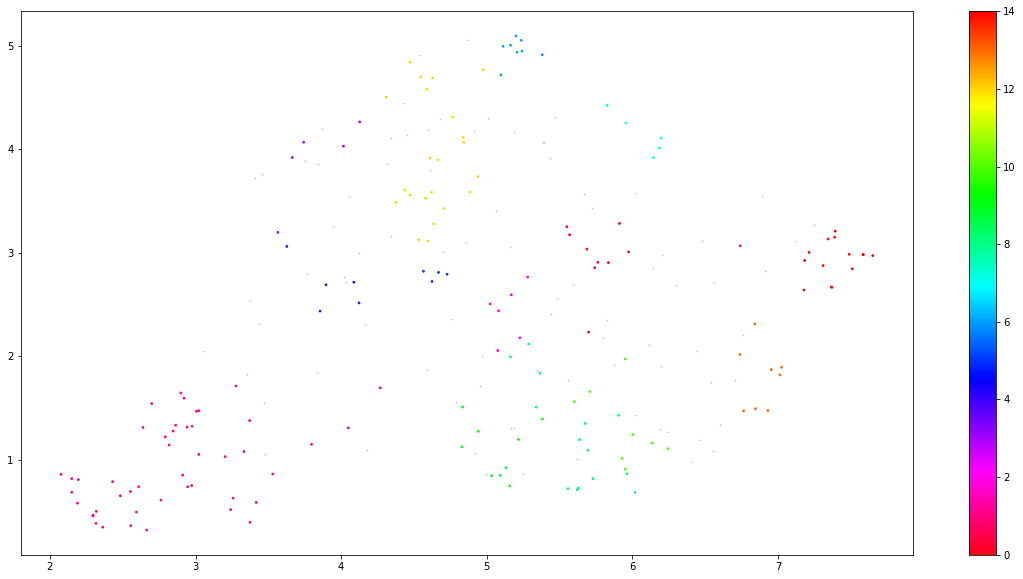

In [65]:
# Prepare data
umap_data = umap.UMAP(n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=3, cmap='hsv_r')
plt.colorbar()

In [66]:
docs_df = pd.DataFrame(texts[:n], columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [67]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(texts[:n]))

In [68]:
tf_idf.shape

(21788, 16)

In [69]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [70]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [71]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,85
2,1,47
13,12,16
9,8,14
15,14,14
1,0,9
10,9,9
7,6,8
11,10,8
14,13,8


In [72]:
k=0
for t in topic_sizes.Topic.values:
    top_n_words[t].sort(key=lambda x:- x[1])
    k +=1
    print('')
    print('Topic - ',k)
    for i in range(10):
        print(top_n_words[t][i][0])


Topic -  1
ges
rigs
advisors
dan
leases
shacks
pilots
hours
advertisers
restaurants

Topic -  2
cells
unmet
preclinical
dosing
drug
surgeons
disease
dose
therapy
doses

Topic -  3
outflows
spreads
msr
janus
abs
cannabis
henderson
stonepine
refi
philippe

Topic -  4
teammates
chargers
philippines
verticals
practitioners
ashwin
guests
clinicians
lenses
visits

Topic -  5
quarter
additives
bonds
grosse
anvesh
apartments
andreas
provisioning
sander
klebert

Topic -  6
students
doors
russ
disposables
tabs
weddell
owners
pools
remodel
interior

Topic -  7
rios
bundles
dezellem
nurses
essi
ferrari
sme
knudson
pen
dun

Topic -  8
voliva
urinary
psp
puget
hep
barrels
griffith
vadala
cheyenne
cracks

Topic -  9
pharmacies
satellites
eocl
porter
vitacare
users
worldview
spacecraft
discounts
voermann

Topic -  10
kuehne
airlines
sports
aircraft
destinations
garage
fares
buffet
leisure
circa

Topic -  11
casella
carla
frontdoor
contractors
mallard
vogensen
cards
murry
proconnect
400g

Topic -  12


## Linear Discriminant Analysis (LDA)
--> supervised learning !

## Latent Dirichlet Allocation (LDA)
#to do how data cleanned / words removeds

In [ ]:
!pip install gensim

In [ ]:
final_doc = [document.split() for document in corpus]

In [ ]:
dictionary = corpora.Dictionary(final_doc)
DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]
Lda_object = gensim.models.ldamodel.LdaModel

In [ ]:
lda_model_1 = Lda_object(DT_matrix, num_topics=2, id2word = dictionary)
print(lda_model_1.show_topics(num_words=10))

## BERT - Test 1

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

embeddings = model.encode(texts[:10], show_progress_bar=True)

embeddings,shape